## 0. 환경설정

In [2]:
!uv pip install langchain_openai
!uv pip install langchain_community

Audited 1 package in 24ms
Audited 1 package in 33ms


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

## 1. Langchain 제공 기능

참고 자료 : https://python.langchain.com/v0.2/docs/how_to/chatbots_memory/

### 1) Message passing
- 이전 대화 내용을 chain에 넘겨주는 것

- The simplest form of memory is simply passing chat history messages into a chain.

In [4]:
from langchain_openai import ChatOpenAI

chat = ChatOpenAI(model="gpt-4o") # gpt-3.5-turbo-0125

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability. YOU MUST ANSWER IN KOREAN.",
        ),
        ("placeholder", "{messages}"),
    ]
)

chain = prompt | chat

ai_msg = chain.invoke(
    {
        "messages": [
            (
                "human",
                "일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘.",
            ),
            ("ai",  "いただきます (이타다키마스)"),
            ("human", "내가 방금 뭐라고 했지?"),
        ],
    }
)
print(ai_msg.content)

당신은 '잘 먹겠습니다.'를 일본어로 어떻게 말하는지 물어보셨습니다.


In [6]:
ai_msg = chain.invoke(
    {
        "messages": [
            (
                "human",
                "내 이름은 민정이고, AI를 공부하는 중이야.",
            ),
            ("ai",  "그렇군요. 흥미로운데요?"),
            ("human", "내가 뭐 하고 있다고?"),
        ],
    }
)
print(ai_msg.content)

당신은 AI를 공부하고 있다고 하셨습니다.


- 응용 : 대화 쌓일 때마다 히스토리 저장하도록 구현

In [7]:
history_list = []
while(True):
    user_input = input()
    if user_input == "종료": break
    history_list.append(
        (
            "human",
            user_input,
        )
    )
    print("## CHAT_HISTORY ##")
    print(history_list, "\n")
    ai_msg = chain.invoke(
        {
            "messages": history_list,
        }
    )
    print("AI Says : ",ai_msg.content)

    history_list.append(
        (
            "ai",
            ai_msg.content,
        )
    )

## CHAT_HISTORY ##
[('human', '안녕')] 

AI Says :  안녕하세요! 무엇을 도와드릴까요?
## CHAT_HISTORY ##
[('human', '안녕'), ('ai', '안녕하세요! 무엇을 도와드릴까요?'), ('human', 'quit')] 

AI Says :  대화를 종료하시려면 "종료" 또는 "끝"이라고 말씀해 주시면 됩니다. 다른 도움이 필요하시면 언제든지 말씀해 주세요!


### 2) Chat history
- ChatMessageHistory() 클래스 사용하기
- It's perfectly fine to store and pass messages directly as an array, but we can use LangChain's built-in message history class to store and load messages as well.

https://api.python.langchain.com/en/latest/chat_message_histories/langchain_community.chat_message_histories.in_memory.ChatMessageHistory.html

In [10]:
from langchain_community.chat_message_histories import ChatMessageHistory

chat_history = ChatMessageHistory()

chat_history.add_user_message(
    "일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘."
)

chat_history.add_ai_message("いただきます (이타다키마스)")

chat_history.messages
# chat_history.clear()

[HumanMessage(content="일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘.", additional_kwargs={}, response_metadata={}),
 AIMessage(content='いただきます (이타다키마스)', additional_kwargs={}, response_metadata={})]

- 대화내용 바로바로 저장하기

In [ ]:
chat_history = ChatMessageHistory()

################ USER INPUT - 1 ################
input1 = "일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘."

# 대화 히스토리에 입력(user_input) 저장
chat_history.add_user_message(input1)
print("첫번째 입력 후 history : ", chat_history.messages)

################ AI RESPONSE - 1 ################
# 답변 생성(response)
response = chain.invoke(
    {
        "messages": chat_history.messages,
    }
)

# 대화 히스토리에 답변(response) 저장
chat_history.add_ai_message(response)
print("첫번째 답변 후 history : ", chat_history.messages)
print()

################ USER INPUT - 2 ################
input2 = "내가 방금 뭐라고 물어봤지?"

# 대화 히스토리에 입력(user_input) 저장
chat_history.add_user_message(input2)
print("두번째 입력 후 history : ", chat_history.messages)

################ AI RESPONSE - 2 ################
# 답변 생성(response)
print("[두번째 입력에 대한 답변]")
chain.invoke(
    {
        "messages": chat_history.messages,
    }
)

첫번째 입력 후 history :  [HumanMessage(content="일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘.", additional_kwargs={}, response_metadata={})]
첫번째 답변 후 history :  [HumanMessage(content="일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘.", additional_kwargs={}, response_metadata={}), AIMessage(content='일본어로 \'잘 먹겠습니다.\'는 "いただきます"라고 말합니다. 한글 발음은 "이타다키마스"입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 59, 'total_tokens': 93, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-1ed0525d-6e28-4e28-9c7a-a8970c5b9c49-0', usage_metadata={'input_tokens': 59, 'output_tokens': 34, 'total_tokens': 93, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]

두번째 입력 후 history :  [HumanMessage(content="일본어로 '잘

AIMessage(content='당신은 "일본어로 \'잘 먹겠습니다.\' 어떻게 말해? 한글 발음도 함께 말해줘."라고 물어보셨습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 112, 'total_tokens': 146, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'stop', 'logprobs': None}, id='run-8a35d5c0-d930-4eef-a5fa-11cf78860163-0', usage_metadata={'input_tokens': 112, 'output_tokens': 34, 'total_tokens': 146, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

- 응용 : 대화 쌓일 때마다 히스토리 저장하도록 구현

In [11]:
chat_history = ChatMessageHistory()

while(True):
    user_input = input()
    if user_input == "종료": break
    chat_history.add_user_message(user_input)
    response = chain.invoke(
        {
            "messages": chat_history.messages,
        }
    )
    chat_history.add_ai_message(response)
    print(response.content)

초콜릿은 정말 맛있죠! 특별히 좋아하는 초콜릿 종류가 있나요? 다크 초콜릿, 밀크 초콜릿, 아니면 화이트 초콜릿을 더 선호하세요?
다크 초콜릿을 좋아하신다면 몇 가지 추천드릴게요:

1. **다크 초콜릿 트러플**: 부드럽고 진한 맛을 느낄 수 있어요.
2. **다크 초콜릿과 아몬드**: 아몬드의 고소함과 초콜릿의 쌉싸름한 맛이 잘 어울려요.
3. **다크 초콜릿 딸기**: 상큼한 딸기와 다크 초콜릿의 조화가 훌륭합니다.
4. **다크 초콜릿 브라우니**: 촉촉하고 진한 브라우니로 초콜릿의 풍미를 즐길 수 있어요.
5. **다크 초콜릿 칩 쿠키**: 쌉싸름한 초콜릿 칩이 들어간 쿠키는 항상 인기 있죠.

어떤 것이든 다크 초콜릿의 깊은 맛을 잘 살릴 수 있는 간식들이니 한번 시도해 보세요!
아, 처음에는 다크 초콜릿을 좋아한다고 말씀하셨는데, 밀크 초콜릿도 좋아하시나요? 밀크 초콜릿도 부드럽고 달콤해서 많은 분들이 좋아하시죠. 혹시 좋아하는 밀크 초콜릿 간식이 있으신가요?


### 3) Automatic history management
- RunnableWithMessageHistory() 활용하여 메모리 관리하기
- The previous examples pass messages to the chain explicitly. This is a completely acceptable approach, but it does require external management of new messages. LangChain also includes an wrapper for LCEL chains that can handle this process automatically called RunnableWithMessageHistory.

In [12]:
chat = ChatOpenAI(model="gpt-4o")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability. YOU MUST ANSWER IN KOREAN.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
    ]
)

chain = prompt | chat

In [13]:
from langchain_core.runnables.history import RunnableWithMessageHistory

chat_history_for_chain = ChatMessageHistory()

chain_with_message_history = RunnableWithMessageHistory(
    chain, # 실행할 Runnable 객체
    lambda session_id: chat_history_for_chain, # 세션 기록을 가져오는 함수
    input_messages_key="input", # 입력 메시지의 Key
    history_messages_key="chat_history", # 대화 히스토리 메시지의 Key
)

In [14]:
chain_with_message_history.invoke(
    {"input": "일본어로 '잘 먹겠습니다.' 어떻게 말해? 한글 발음도 함께 말해줘."},
    {"configurable": {"session_id": "unused"}},
)

AIMessage(content='일본어로 \'잘 먹겠습니다.\'는 "いだだきます"라고 말합니다. 한글 발음은 \'이타다키마스\'입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 59, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e1dc348028', 'id': 'chatcmpl-CnLhNtz73mN4VxoP93v8Esi4nzkjF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2680-8b33-7311-9bce-65c6b30a9515-0', usage_metadata={'input_tokens': 59, 'output_tokens': 36, 'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [15]:
chain_with_message_history.invoke(
    {"input": "내가 뭐라고 물어봤지?"}, {"configurable": {"session_id": "unused"}}
)

AIMessage(content="당신은 '잘 먹겠습니다.'를 일본어로 어떻게 말하는지 물어보셨습니다. 또한 한글 발음도 함께 요청하셨습니다.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 112, 'total_tokens': 146, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e1dc348028', 'id': 'chatcmpl-CnLhWULKr1a6icoWJ8R2ky8pUfo2E', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2680-aaaf-76f0-82c2-0ce653913d88-0', usage_metadata={'input_tokens': 112, 'output_tokens': 34, 'total_tokens': 146, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

히스토리 저장 함수를 따로 호출할 필요없이 invoke 실행만으로 대화 기록이 자동 저장되는 것을 확인 가능!

### 4) Modifying chat history
- 이전 대화 내용을 가공하여 넘겨주기
- Modifying stored chat messages can help your chatbot handle a variety of situations.

In [16]:
chat_history = ChatMessageHistory()

chat_history.add_user_message("안녕하세요. 제 이름은 나연입니다.")
chat_history.add_ai_message("안녕하세요, 나연님! 무엇을 도와드릴까요?")
chat_history.add_user_message("날씨 좋은 날 들을만 한 노래 추천해주세요.")
chat_history.add_ai_message("Carpenters - Close to you 를 추천해요.")

chat_history.messages
# chat_history.clear()

[HumanMessage(content='안녕하세요. 제 이름은 나연입니다.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='안녕하세요, 나연님! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='날씨 좋은 날 들을만 한 노래 추천해주세요.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Carpenters - Close to you 를 추천해요.', additional_kwargs={}, response_metadata={})]

In [17]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability. The provided chat history includes facts about the user you are speaking with. YOU MUST ANSWER IN KOREAN.",
        ),
        ("placeholder", "{chat_history}"),
        ("user", "{input}"),
    ]
)

chain = prompt | chat

chain_with_message_history = RunnableWithMessageHistory(
    chain,
    lambda session_id: chat_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [18]:
from langchain_core.runnables import RunnablePassthrough

def summarize_messages(chain_input):
    stored_messages = chat_history.messages
    if len(stored_messages) == 0:
        return False
    summarization_prompt = ChatPromptTemplate.from_messages(
        [
            ("placeholder", "{chat_history}"),
            (
                "user",
                "Distill the above chat messages into a single summary message. Include as many specific details as you can.",
            ),
        ]
    )
    summarization_chain = summarization_prompt | chat

    # chat_history 에 저장된 대화 기록을 요약프롬프트에 입력 & 결과 저장
    summary_message = summarization_chain.invoke({"chat_history": stored_messages})

    # chat_history 에 저장되어있던 기록 지우기
    chat_history.clear()

    # 생성된 새로운 요약내용으로 기록 채우기
    chat_history.add_message(summary_message)

    return True

chain_with_summarization = (
    RunnablePassthrough.assign(messages_summarized=summarize_messages)
    | chain_with_message_history
)

- summarize_messages 함수의 실행 결과를 messages_summarized 라는 이름의 Key 로 저장

    - 정의한 chain 안에 "messages_summarized" Key 가 정의되고 있지 않으므로, 이는 `summarize_messages` 함수를 실행하기 위한 무시 가능한 Key
    - 함수가 실행되면 chat_history 에 요약된 히스토리가 저장됨


In [19]:
chain_with_summarization.invoke(
    {"input": "제 이름을 기억하고 있나요?"},
    {"configurable": {"session_id": "unused"}},
)

AIMessage(content='네, 나연님이라고 하셨죠. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 102, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e1dc348028', 'id': 'chatcmpl-CnLhz9T44hdhCP7pnVNTnGvXelSga', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2681-1893-7d23-8c9e-e542b65469bd-0', usage_metadata={'input_tokens': 102, 'output_tokens': 17, 'total_tokens': 119, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
chain_with_summarization.invoke(
    {"input": "그 가수는 남자인가요 여자인가요?"},
    {"configurable": {"session_id": "unused"}},
)

AIMessage(content='Carpenters는 남매 듀오로, 리처드 카펜터와 카렌 카펜터로 구성되어 있습니다. 카렌 카펜터는 여성 보컬리스트입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 109, 'total_tokens': 153, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'stop', 'logprobs': None}, id='run-20fa421b-37ee-49f2-8af2-dbc6ea408fd6-0', usage_metadata={'input_tokens': 109, 'output_tokens': 44, 'total_tokens': 153, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

## 2. 끝말잇기 게임 구현하기

- 4) Modifying chat history 의 활용!

In [2]:
# 대화 기록을 저장할 히스토리 클래스 불러오기
chat_history = ChatMessageHistory()

chat_history.add_user_message("끝말잇기 하자")
chat_history.add_ai_message("좋습니다. 제가 먼저 시작할게요. 바나나!")
chat_history.add_user_message("나이테")
chat_history.add_ai_message("테이프")

chat_history.messages

NameError: name 'ChatMessageHistory' is not defined

In [ ]:
chat = ChatOpenAI(model="gpt-4o")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """당신은 끝말잇기 게임을 진행하는 AI 챗봇입니다. 아래는 게임 규칙입니다. 당신과 user 의 입력에서 아래 규칙이 꼭 지켜져야 하며, 지키지 않은 사람에게 패배를 알린 뒤, 끝말잇기 게임을 종료합니다.
                1. 주어진 대화 기록에서 이미 나왔던 단어를 다시 말했을 경우 패배합니다.
                2. 두음법칙을 허용합니다. (ex. 리 -> 이, 력 -> 역, 락 -> 낙)
                3. 국어사전에 존재하는 단어이자, 명사여야 합니다.
            """,
        ),
        ("placeholder", "{chat_history}"),
        ("user", "{input}"),
    ]
)

chain = prompt | chat

chain_with_message_history = RunnableWithMessageHistory(
    chain,
    lambda session_id: chat_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [ ]:
def summarize_messages(chain_input):
    stored_messages = chat_history.messages
    if len(stored_messages) == 0:
        return False
    summarization_prompt = ChatPromptTemplate.from_messages(
        [
            ("placeholder", "{chat_history}"),
            (
                "user",
                "위 채팅 메시지는 끝말잇기 게임을 진행한 대화내용입니다. 언급한 단어들만 나열하여 저장해주세요.",
            ),
        ]
    )
    summarization_chain = summarization_prompt | chat

    # chat_history 에 저장된 대화 기록을 요약프롬프트에 입력 & 결과 저장
    summary_message = summarization_chain.invoke({"chat_history": stored_messages})

    # chat_history 에 저장되어있던 기록 지우기
    chat_history.clear()

    # 생성된 새로운 요약내용으로 기록 채우기
    chat_history.add_message(summary_message)

    return True


chain_with_summarization = (
    RunnablePassthrough.assign(messages_summarized=summarize_messages)
    | chain_with_message_history
)

In [ ]:
while(True):
    user_input = input("🙋‍♂️ YOUR TURN : ")
    print("🙋‍♂️ YOUR TURN : ", user_input)
    if user_input == "종료": break
    response = chain_with_summarization.invoke(
                {"input": user_input},
                {"configurable": {"session_id": "unused"}},
            )
    print("✍ AI TURN : ", response.content)

🙋‍♂️ YOUR TURN :  바다
✍ AI TURN :  다리
🙋‍♂️ YOUR TURN :  리어카
✍ AI TURN :  카메라
🙋‍♂️ YOUR TURN :  라디오
✍ AI TURN :  오토바이
🙋‍♂️ YOUR TURN :  이발소
✍ AI TURN :  소방차
🙋‍♂️ YOUR TURN :  차림표
✍ AI TURN :  표지판
🙋‍♂️ YOUR TURN :  종료


AI 에이전트 란?

`주변 환경을 감각을 통해 인식하고 의사결정을 내려 행동하는 인공적인 개체`

이를 위해서는
감각 : 외부환경과 사용자의 요청 인식
두뇌 : 가지고 있는 지식이나 지금까지의 기억을 확인하고 계획,
      추론을 통해 다음에 어떤 행동을 할 지에 대한 의사 결정.
행동 : 문제를 해결하기 위해 취할 수 있는 적절한 도구를 선택해 움직임.

에이전트의 작동 방식은 사람의 사고 과정과 유사함.

#MCP -멀티 컨테이너 프로토콜
Model Context Protocol

하나의 호스트 환경에서 여러개의 독립된 서버(컨테이너)와 클라이언트 도구들을 유기적으로 연결하기 위해 고안된 프로토콜
 - LLM과 도구(tool)의 연결 표준화
 - 사전 구축된 다양한 컨텍스트 도구 연결
 - 유연하고 확장 가능한 시스템


서버 - 클라이언트 - 호스트   의 구조
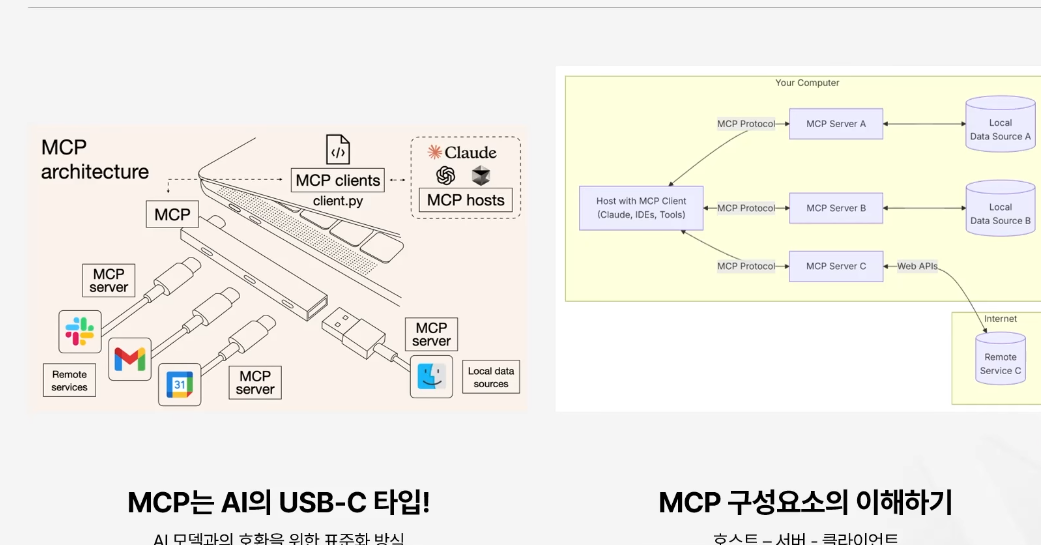



서버 : 서버는 특정 데이터 소스(파일 시스템, 데이터베이스)나 외부 도구(GitHub API, Slack API)를 MCP 표준에 맞춰 감싼(wrapping) 경량 어댑터.

클라이언트 : 클라이언트는 호스트 내에 존재하며, 특정 서버와 1:1로 직접 통신하는 중재자.
 - 통신담당 JSON-RCP 방식: ?

호스트 : 사용자가 직접 상호작용하는 최상위 AI



#MCP 구현요소

Resources
: AI모델에게 필요한 정보와 컨텍스트를 제공

Tools
: AI 모델이 외부 시스템에서 작업을 수행할 수 있도록 도구를 정의

Prompt
: AI 모델이 리소스와 도구를 활용하여 응답을 생성할 수 있도록 재사용 가능한 템플릿 제공.


멀티 에이전트

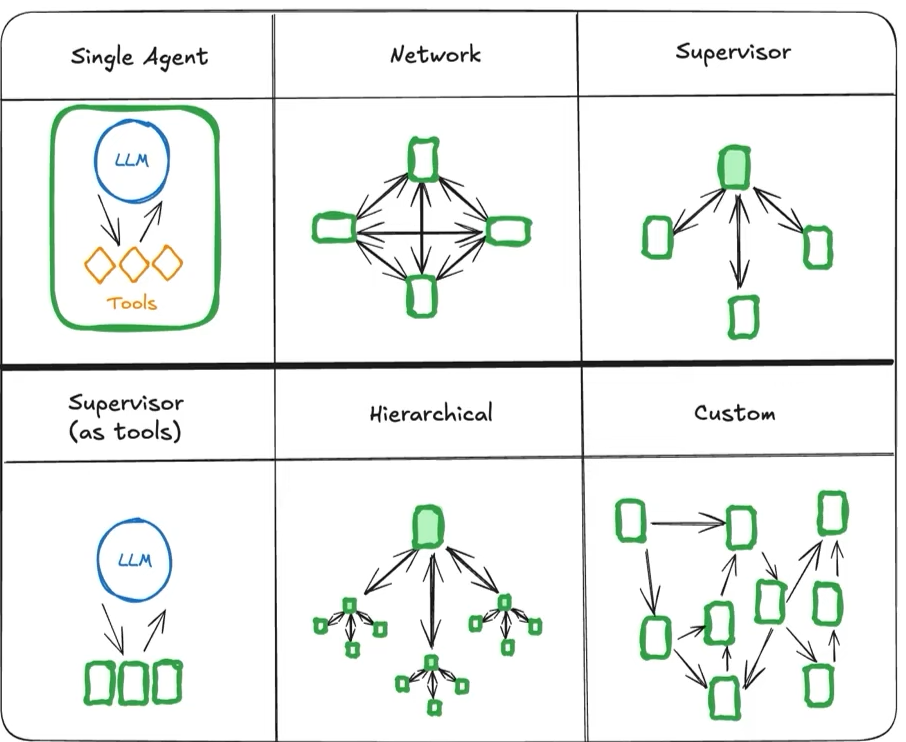